In [1]:

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# process load time data
systems = ['Baseline', 'DLCache']
compute_time = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
batch_size = [512, 1024, 2048]
repeats = 3
data = []

for s in systems:
    for r in range(repeats):
        for b in batch_size:
            for c in compute_time:
                try:
                    dir = "{}/run{}/{}/{}".format(s, r, c, b)
                    load_time = np.sum(np.load('{}/load_time.npy'.format(dir)))
                    if os.path.exists('{}/train_cache_usage.npy'.format(dir)):
                        avg_cache_usage = np.load('{}/train_cache_usage.npy'.format(dir))
                        avg_cache_usage = np.mean(avg_cache_usage, dtype=int) / 2
                        cache_hits = 0
                        for ch in glob.glob("{}/cache_hits*".format(dir)):
                            cache_hits += np.load(ch)
                        cache_hit_rate = cache_hits / (b * 100)
                    else:
                        avg_cache_usage = 0
                        cache_hit_rate = 0
                    data.append([s, c, b, load_time, avg_cache_usage, cache_hit_rate])
                except Exception as ex:
                    pass

data = pd.DataFrame(data, columns=['Method', 'compute_time', 'batch_size', 'load_time', 'avg_cache_usage', 'cache_hit_rate'])
data.sort_values(by='compute_time', inplace=True)
data.to_csv('data.csv', index=False)

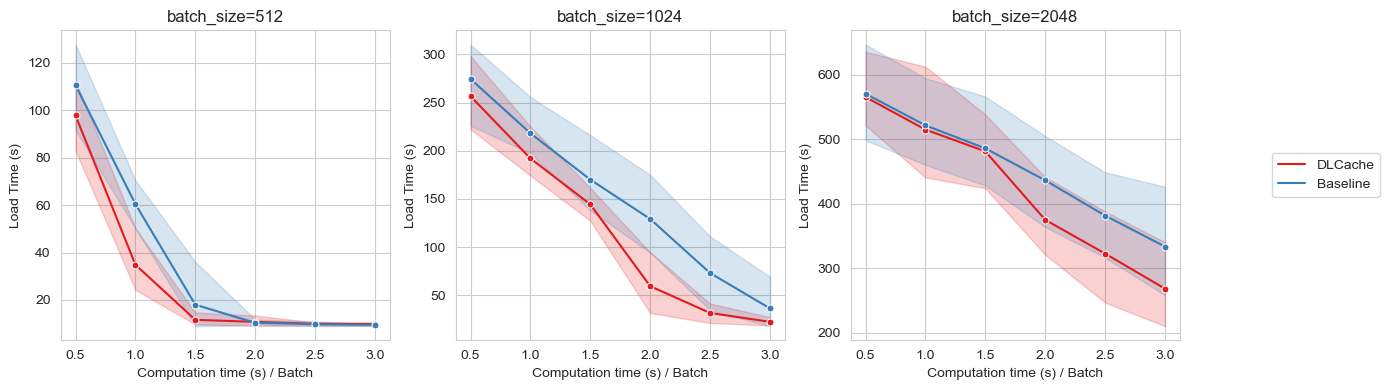

In [2]:
fig, axes = plt.subplots(1, len(batch_size), figsize=(4*len(batch_size), 4))

markers = ['.', '*']
for j, b in enumerate(batch_size):
    slice = data[data['batch_size']==b].sort_values(by='compute_time')
    compute_time_ticks = []
    for ct in slice['compute_time']:
        compute_time_ticks.append(compute_time.index(ct))
    slice['compute_time'] = compute_time_ticks
    # ax = sns.boxplot(ax=axes[j], data=slice, x='compute_time', y='load_time', hue='Method', hue_order=['DLCache', 'Baseline'])
    ax = sns.lineplot(ax=axes[j], data=slice, x='compute_time', y='load_time', hue='Method', hue_order=['DLCache', 'Baseline'], 
                        marker='.', markersize=10, palette = "Set1")
    ax.get_legend().remove()
    ax.set_xticks(np.arange(len(compute_time)))
    ax.set_xticklabels(compute_time)
    ax.set_xlabel('Computation time (s) / Batch')
    ax.set_ylabel('Load Time (s)')
    ax.set_title('batch_size={}'.format(b))

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', ncol=1, bbox_to_anchor=(1.16, 0.55))
plt.tight_layout()
plt.savefig("./images/load_time.png", dpi=300)
plt.show()

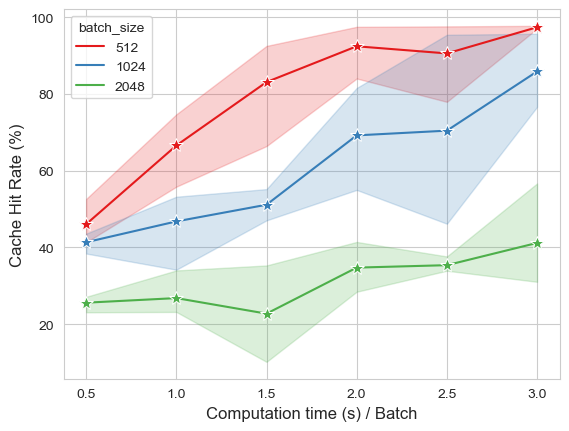

In [3]:
slice = data[(data['Method']=='DLCache')].sort_values(by='compute_time')
compute_time_ticks = []
for ct in slice['compute_time']:
    compute_time_ticks.append(compute_time.index(ct))
slice['compute_time'] = compute_time_ticks
slice['cache_hit_rate'] *= 100.0
ax = sns.lineplot(x='compute_time', y='cache_hit_rate', data=slice, hue='batch_size', marker= '*', markersize=10, palette = "Set1")
ax.set_xticks(np.arange(len(compute_time)))
ax.set_xticklabels(compute_time)
ax.set_xlabel('Computation time (s) / Batch', fontsize=12)
ax.set_ylabel('Cache Hit Rate (%)', fontsize=12)
plt.savefig("./images/cache_hit.png", dpi=300)
plt.show()

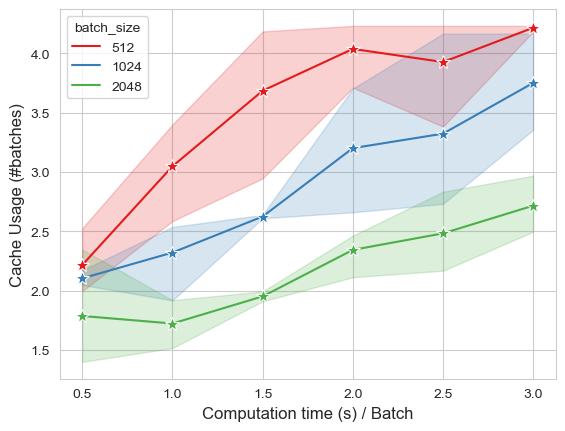

In [4]:
slice = data[(data['Method']=='DLCache')].sort_values(by='compute_time')
compute_time_ticks = []
for ct in slice['compute_time']:
    compute_time_ticks.append(compute_time.index(ct))
slice['compute_time'] = compute_time_ticks
slice['cache_usage'] = slice['avg_cache_usage'] / slice['batch_size']
ax = sns.lineplot(x='compute_time', y='cache_usage', data=slice, hue='batch_size', marker= '*', markersize=10, palette = "Set1")
ax.set_xticks(np.arange(len(compute_time)))
ax.set_xticklabels(compute_time)
ax.set_xlabel('Computation time (s) / Batch', fontsize=12)
ax.set_ylabel('Cache Usage (#batches)', fontsize=12)
plt.savefig("./images/cache_usage.png", dpi=300)
plt.show()